In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brands/brands_data.csv
/kaggle/input/sentiment/influencer_sentiment_scores_final.csv
/kaggle/input/influencercont/brands_df_final.csv
/kaggle/input/influencercont/influencers_df_final.csv
/kaggle/input/influencercont/mlpr.csv


In [2]:
import pandas as pd
import numpy as np

# Step 1: Load the data
brands_df = pd.read_csv('/kaggle/input/influencercont/brands_df_final.csv')
influencers_df = pd.read_csv('/kaggle/input/influencercont/influencers_df_final.csv')
mlpr = pd.read_csv('/kaggle/input/influencercont/mlpr.csv')




In [3]:
brand= pd.read_csv('/kaggle/input/brands/brands_data.csv')

/tmp/ipykernel_13/4065972476.py:1: DtypeWarning: Columns (3,4,5,6,7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  brand= pd.read_csv('/kaggle/input/brands/brands_data.csv')


In [4]:
sponsorship_pairs = set(
    zip(
        mlpr['sponsor_user_username'].dropna().str.lower(),    # Brand usernames
        mlpr['User'].dropna().str.lower()                      # Influencer usernames
    )
)


In [5]:
import pandas as pd
import numpy as np

def is_sponsored(brand_username, influencer_username):
    if pd.isna(brand_username) or pd.isna(influencer_username):
        return 0
    return 1 if (brand_username.lower(), influencer_username.lower()) in sponsorship_pairs else 0

# Step 4: Create final list of rows
final_rows = []

# How many random non-sponsored influencers you want to sample per brand
n_non_sponsored_per_brand = 10

# Iterate over each brand
for idx, brand_row in brands_df.iterrows():
    brand_username = brand_row['Brand Username']
    
    # Find all influencers sponsored by this brand
    sponsored_influencers = mlpr[
        mlpr['sponsor_user_username'].str.lower() == str(brand_username).lower()
    ]['User'].dropna().unique()
    
    # Sponsored influencers (sponsorship_final = 1)
    for influencer_username in sponsored_influencers:
        influencer_info = influencers_df[influencers_df['User'].str.lower() == influencer_username.lower()]
        
        if not influencer_info.empty:
            row = {
                'Brand Username': brand_username,
                'Brand Bio': brand_row.get('Bio', np.nan),
                'Brand Category': brand_row.get('Brand Category', np.nan),
                'Influencer Username': influencer_username,
                'Influencer Name': influencer_info.iloc[0].get('Influencer Name', np.nan),
                'Influencer Category': influencer_info.iloc[0].get('Influencer Category', np.nan),
                'Influencer Bio': influencer_info.iloc[0].get('Bio', np.nan),
                'Influencer Followers': influencer_info.iloc[0].get('Followers', np.nan),
                'Influencer Engagement Rate': influencer_info.iloc[0].get('Engagement Rate', np.nan),
                'sponsorship_final': 1
            }
            final_rows.append(row)

    # Non-sponsored influencers with non-null Bio
    all_influencers_set = set(
        influencers_df[~influencers_df['Bio'].isna()]['User'].dropna().str.lower()
    )
    sponsored_set = set(map(str.lower, sponsored_influencers))
    non_sponsored_influencers = list(all_influencers_set - sponsored_set)
    
    if len(non_sponsored_influencers) >= n_non_sponsored_per_brand:
        sampled_non_sponsored = np.random.choice(non_sponsored_influencers, n_non_sponsored_per_brand, replace=False)
    else:
        sampled_non_sponsored = non_sponsored_influencers

    for influencer_username in sampled_non_sponsored:
        influencer_info = influencers_df[influencers_df['User'].str.lower() == influencer_username]
        
        if not influencer_info.empty:
            row = {
                'Brand Username': brand_username,
                'Brand Bio': brand_row.get('Bio', np.nan),
                'Brand Category': brand_row.get('Brand Category', np.nan),
                'Influencer Username': influencer_info.iloc[0]['User'],
                'Influencer Name': influencer_info.iloc[0].get('Influencer Name', np.nan),
                'Influencer Category': influencer_info.iloc[0].get('Influencer Category', np.nan),
                'Influencer Bio': influencer_info.iloc[0].get('Bio', np.nan),
                'Influencer Followers': influencer_info.iloc[0].get('Followers', np.nan),
                'Influencer Engagement Rate': influencer_info.iloc[0].get('Engagement Rate', np.nan),
                'sponsorship_final': 0
            }
            final_rows.append(row)

# Step 5: Create the final dataframe
final_df = pd.DataFrame(final_rows)


In [6]:
final_df.size

227590

In [7]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

# Fill NaNs
final_df['Brand Bio'] = final_df['Brand Bio'].fillna('')
final_df['Influencer Bio'] = final_df['Influencer Bio'].fillna('')

# Load a pre-trained sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight and fast

# Encode bios
brand_embeddings = model.encode(final_df['Brand Bio'].tolist(), show_progress_bar=True)
influencer_embeddings = model.encode(final_df['Influencer Bio'].tolist(), show_progress_bar=True)

# Compute cosine similarity row-wise
similarities = [
    cosine_similarity([brand_embeddings[i]], [influencer_embeddings[i]])[0][0]
    for i in range(len(final_df))
]

# Add similarity to dataframe
final_df['bio_similarity'] = similarities


2025-05-12 15:59:31.392331: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747065571.673217      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747065571.749888      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/712 [00:00<?, ?it/s]

Batches:   0%|          | 0/712 [00:00<?, ?it/s]

In [8]:
final_df[final_df['sponsorship_final'] == 1][['Brand Bio', 'Influencer Bio','bio_similarity']]


,Brand Bio,Influencer Bio,bio_similarity
0,"Celebrating how delicious, organic herbal teas...",I can't dance but I can burpee 🖥 Digital Ed @W...,0.268495
1,"Celebrating how delicious, organic herbal teas...",🇬🇧 Lifestyle Vlogger 📕 Author of Eat Smart 🍓 C...,0.334331
12,Air and Space Power to Protect our Nation,Love Island 2017 Management: Jadeen@Johnnoel.com,0.016247
13,Air and Space Power to Protect our Nation,London Boohoo ambassador Hello@84World.com ...,0.080258
24,#ThisIsAnn Shop our Instagram feed:,"Boston, MA // Will travel for 🍜🍣🍦",0.109824
...,...,...,...
22724,@theellenfund @ellentube @theellenshop,confident curves & sassy style. 💋 a body posit...,0.168464
22735,Download the LIKEtoKNOW.it app now to Shop You...,Somewhere between Lisa Bonet & Zoe Kravitz co-...,0.151144
22736,Download the LIKEtoKNOW.it app now to Shop You...,confident curves & sassy style. 💋 a body posit...,0.156597
22747,Revealing You. Revealing Beautiful Skin.,🇫🇷🇮🇷French/Persian. Esthetician. Blogger. 📍San...,0.190185


In [9]:
final_df.loc[final_df['bio_similarity'] > 0.45, 'sponsorship_final'] = 1


In [10]:
final_df[final_df['bio_similarity'] >0.45][['Brand Bio', 'Influencer Bio','bio_similarity','sponsorship_final']].head(100)


,Brand Bio,Influencer Bio,bio_similarity,sponsorship_final
30,#ThisIsAnn Shop our Instagram feed:,FASHION BLOGGER 🐤| Twitter: iidesign8 📸| Yout...,0.504830,1
52,Mom•Model•Activist Founder of @nowrongwaymovem...,Creative spirit ✨ Co-founder & ECD @refinery29...,0.469690,1
59,Mom•Model•Activist Founder of @nowrongwaymovem...,Jen - mom of 5 - blended family. #ColorfulHapp...,0.451450,1
156,💌 Express shipping worldwide ⚡️ Pay later // A...,🍒🍒🍒 🐣twitter:@chloemorello 📥kevin@renegade-mgm...,0.477622,1
189,Award Winning Makeup / Beauty Brand 💫 Our Luxu...,"Wifey💍Mummy❤️ Ireland📍 Sharing Fashion, Beaut...",0.586366,1
...,...,...,...,...
7968,#shopart #shopartonline #shopartmania,Fashion | Lifestyle ♡ Los Angeles 🌴 #ideesde...,0.511060,1
7988,"For this month, submit your work using #Ps_Eer...","Photo, adventures, healing, ✨life✨ / add to #w...",0.464206,1
8023,Good design for better living. Share your pho...,A design & photography enthusiastic student / ...,0.490287,1
8144,Professional makeup brand for all � Tag #nyxco...,▪️Graphic Designer ▫️Bristol ▪️Hauwei P20 Pro ...,0.471225,1


In [11]:
final_df = pd.merge(
    final_df,
    brands_df[['Brand Username', 'Brand Name']],
    on='Brand Username',
    how='left'
)


In [12]:
final_df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Brand Username,Brand Bio,Brand Category,Influencer Username,Influencer Name,Influencer Category,Influencer Bio,Influencer Followers,Influencer Engagement Rate,sponsorship_final,bio_similarity,Brand Name
0,pukkaherbs,"Celebrating how delicious, organic herbal teas...",Grocery & Convenience Stores,wellness_ed,Amy Hopkinson,Publishers,I can't dance but I can burpee 🖥 Digital Ed @W...,46736.0,1.076717,1,0.268495,Pukka Herbs
1,pukkaherbs,"Celebrating how delicious, organic herbal teas...",Grocery & Convenience Stores,niomismart,Niomi Smart,NaN,🇬🇧 Lifestyle Vlogger 📕 Author of Eat Smart 🍓 C...,1685570.0,0.421798,1,0.334331,Pukka Herbs
2,pukkaherbs,"Celebrating how delicious, organic herbal teas...",Grocery & Convenience Stores,divinelifestyleblog,Stacie Connerty,Personal Goods & General Merchandise Stores,#LifestyleBlogger #TravelWriter #Atlanta #Atla...,26511.0,2.014258,0,0.234725,Pukka Herbs
3,pukkaherbs,"Celebrating how delicious, organic herbal teas...",Grocery & Convenience Stores,camilomontoya,camilomontoya,NaN,Tv Personality. Storyteller,91926.0,NaN,0,0.004368,Pukka Herbs
4,pukkaherbs,"Celebrating how delicious, organic herbal teas...",Grocery & Convenience Stores,ragdollgino,Hi! We are three Ragdoll cats,General Interest,🌸 Gino (11/07/2014) Blue bicolor 🌸 Levi (08...,36691.0,4.415252,0,0.197042,Pukka Herbs
...,...,...,...,...,...,...,...,...,...,...,...,...
34564,europeanwax,Revealing You. Revealing Beautiful Skin.,Transportation & Accomodation Services,schini_mini_,𝑆𝑐ℎ𝑒𝑟𝑖𝑛,NaN,∘𝐵𝑜𝑛𝑛 ⚓️ ∘𝑇𝑒𝑎𝑐ℎ𝑒𝑟 ✎ ∘𝑂𝑏𝑠𝑒𝑠𝑠𝑒𝑑 𝐶𝑎𝑡𝑚𝑜𝑚 ∘𝐖𝐢𝐟𝐞 𝐭𝐨 ...,6005.0,NaN,0,0.013050,European Wax Center
34565,europeanwax,Revealing You. Revealing Beautiful Skin.,Transportation & Accomodation Services,j_charrr_,jessa chargois,General Interest,"nyc assistant @talliaorange ""type a"" gal who ...",1731.0,NaN,0,0.197422,European Wax Center
34566,europeanwax,Revealing You. Revealing Beautiful Skin.,Transportation & Accomodation Services,petesnodden,petesnodden,Creators & Celebrities,👉#Broadcaster #Presenter ➡️ #Radio #TV #EventH...,23956.0,1.769912,0,0.048125,European Wax Center
34567,europeanwax,Revealing You. Revealing Beautiful Skin.,Transportation & Accomodation Services,intotopr,TOTO PR,Publishers,TOTO PR & MANAGEMENT : Celebrity // Influencer...,2141.0,3.082672,0,0.143689,European Wax Center


In [13]:
final_df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Brand Username,Brand Bio,Brand Category,Influencer Username,Influencer Name,Influencer Category,Influencer Bio,Influencer Followers,Influencer Engagement Rate,sponsorship_final,bio_similarity,Brand Name
0,pukkaherbs,"Celebrating how delicious, organic herbal teas...",Grocery & Convenience Stores,wellness_ed,Amy Hopkinson,Publishers,I can't dance but I can burpee 🖥 Digital Ed @W...,46736.0,1.076717,1,0.268495,Pukka Herbs
1,pukkaherbs,"Celebrating how delicious, organic herbal teas...",Grocery & Convenience Stores,niomismart,Niomi Smart,NaN,🇬🇧 Lifestyle Vlogger 📕 Author of Eat Smart 🍓 C...,1685570.0,0.421798,1,0.334331,Pukka Herbs
2,pukkaherbs,"Celebrating how delicious, organic herbal teas...",Grocery & Convenience Stores,divinelifestyleblog,Stacie Connerty,Personal Goods & General Merchandise Stores,#LifestyleBlogger #TravelWriter #Atlanta #Atla...,26511.0,2.014258,0,0.234725,Pukka Herbs
3,pukkaherbs,"Celebrating how delicious, organic herbal teas...",Grocery & Convenience Stores,camilomontoya,camilomontoya,NaN,Tv Personality. Storyteller,91926.0,NaN,0,0.004368,Pukka Herbs
4,pukkaherbs,"Celebrating how delicious, organic herbal teas...",Grocery & Convenience Stores,ragdollgino,Hi! We are three Ragdoll cats,General Interest,🌸 Gino (11/07/2014) Blue bicolor 🌸 Levi (08...,36691.0,4.415252,0,0.197042,Pukka Herbs
...,...,...,...,...,...,...,...,...,...,...,...,...
34564,europeanwax,Revealing You. Revealing Beautiful Skin.,Transportation & Accomodation Services,schini_mini_,𝑆𝑐ℎ𝑒𝑟𝑖𝑛,NaN,∘𝐵𝑜𝑛𝑛 ⚓️ ∘𝑇𝑒𝑎𝑐ℎ𝑒𝑟 ✎ ∘𝑂𝑏𝑠𝑒𝑠𝑠𝑒𝑑 𝐶𝑎𝑡𝑚𝑜𝑚 ∘𝐖𝐢𝐟𝐞 𝐭𝐨 ...,6005.0,NaN,0,0.013050,European Wax Center
34565,europeanwax,Revealing You. Revealing Beautiful Skin.,Transportation & Accomodation Services,j_charrr_,jessa chargois,General Interest,"nyc assistant @talliaorange ""type a"" gal who ...",1731.0,NaN,0,0.197422,European Wax Center
34566,europeanwax,Revealing You. Revealing Beautiful Skin.,Transportation & Accomodation Services,petesnodden,petesnodden,Creators & Celebrities,👉#Broadcaster #Presenter ➡️ #Radio #TV #EventH...,23956.0,1.769912,0,0.048125,European Wax Center
34567,europeanwax,Revealing You. Revealing Beautiful Skin.,Transportation & Accomodation Services,intotopr,TOTO PR,Publishers,TOTO PR & MANAGEMENT : Celebrity // Influencer...,2141.0,3.082672,0,0.143689,European Wax Center


In [14]:
# Merge Followers from brand into final_df by matching brand.name to final_df['Brand Name']
final_df = pd.merge(
    final_df,
    brand[['Name', 'Followers']].rename(columns={'Name': 'Brand Name'}),
    on='Brand Name',
    how='left',
    suffixes=('', '_from_brand_df')  # Optional, in case of duplicates
)


In [15]:
final_df["Influencer Username"].nunique()

15797

In [16]:
final_df["Brand Username"].nunique()

1597

In [17]:
final_df.head(20)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Brand Username,Brand Bio,Brand Category,Influencer Username,Influencer Name,Influencer Category,Influencer Bio,Influencer Followers,Influencer Engagement Rate,sponsorship_final,bio_similarity,Brand Name,Followers
0,pukkaherbs,"Celebrating how delicious, organic herbal teas...",Grocery & Convenience Stores,wellness_ed,Amy Hopkinson,Publishers,I can't dance but I can burpee 🖥 Digital Ed @W...,46736.0,1.076717,1,0.268495,Pukka Herbs,61353.0
1,pukkaherbs,"Celebrating how delicious, organic herbal teas...",Grocery & Convenience Stores,niomismart,Niomi Smart,NaN,🇬🇧 Lifestyle Vlogger 📕 Author of Eat Smart 🍓 C...,1685570.0,0.421798,1,0.334331,Pukka Herbs,61353.0
2,pukkaherbs,"Celebrating how delicious, organic herbal teas...",Grocery & Convenience Stores,divinelifestyleblog,Stacie Connerty,Personal Goods & General Merchandise Stores,#LifestyleBlogger #TravelWriter #Atlanta #Atla...,26511.0,2.014258,0,0.234725,Pukka Herbs,61353.0
3,pukkaherbs,"Celebrating how delicious, organic herbal teas...",Grocery & Convenience Stores,camilomontoya,camilomontoya,NaN,Tv Personality. Storyteller,91926.0,NaN,0,0.004368,Pukka Herbs,61353.0
4,pukkaherbs,"Celebrating how delicious, organic herbal teas...",Grocery & Convenience Stores,ragdollgino,Hi! We are three Ragdoll cats,General Interest,🌸 Gino (11/07/2014) Blue bicolor 🌸 Levi (08...,36691.0,4.415252,0,0.197042,Pukka Herbs,61353.0
5,pukkaherbs,"Celebrating how delicious, organic herbal teas...",Grocery & Convenience Stores,abigail__elizabeth,Abigail Elizabeth ♡,NaN,▪Abigail ▪23 ▪Blogger 📃 ▪Parenting 👨‍👩‍👧‍👦 ▪Fo...,10638.0,NaN,0,0.181937,Pukka Herbs,61353.0
6,pukkaherbs,"Celebrating how delicious, organic herbal teas...",Grocery & Convenience Stores,xoxo.its.b,Brianna White || prettyandpink,Creators & Celebrities,"Fashion + Beauty + Lifestyle 📍Memphis, TN || M...",1097.0,NaN,0,0.201706,Pukka Herbs,61353.0
7,pukkaherbs,"Celebrating how delicious, organic herbal teas...",Grocery & Convenience Stores,sissychristidou,Sissy Christidou,Creators & Celebrities,• Mom👱🏻👦🏼🐶🕊 • Wife👨🏻‍🎤 • Doer 👊🏻 • Creating st...,513719.0,NaN,0,0.207951,Pukka Herbs,61353.0
8,pukkaherbs,"Celebrating how delicious, organic herbal teas...",Grocery & Convenience Stores,chelsealinder,CHELSEA LINDER 🖤,Creators & Celebrities,Jersey/Los Angeles Snapchat:ChelseaLinder Bus...,43582.0,NaN,0,0.036543,Pukka Herbs,61353.0
9,pukkaherbs,"Celebrating how delicious, organic herbal teas...",Grocery & Convenience Stores,bosschickportia,Portia S | Fitness + Lifestyle,Home Services,💍Wife🤰🏽Fit Pregancy 💃🏽Master Trainer @bosschic...,3564.0,50.615530,0,0.254256,Pukka Herbs,61353.0


In [18]:
# Display the total number of NaN values in the entire DataFrame
final_df.isna().sum().sum()


30525

In [19]:
final_df['Influencer Engagement Rate'] = final_df['Influencer Engagement Rate'].fillna(final_df['Influencer Engagement Rate'].mean())

final_df['Followers'] = final_df['Followers'].fillna(final_df['Followers'].mean())
# Fill categorical columns
final_df['Influencer Category'] = final_df['Influencer Category'].fillna('Unknown')

In [20]:
# Display the total number of NaN values in the entire DataFrame
final_df.isna().sum().sum()


340

In [21]:
# Step 1: Load the sentiment scores file
sentiment_df = pd.read_csv("/kaggle/input/sentiment/influencer_sentiment_scores_final.csv")

# Step 2: Merge with final_df on matching influencer usernames
final_df = final_df.merge(
    sentiment_df,
    how='left',
    left_on='Influencer Username',
    right_on='User'
)


final_df = final_df.drop(columns=['User'])



In [22]:
final_df['sentiment_score'] = final_df['sentiment_score'].fillna(0)

In [23]:
final_df

,Brand Username,Brand Bio,Brand Category,Influencer Username,Influencer Name,Influencer Category,Influencer Bio,Influencer Followers,Influencer Engagement Rate,sponsorship_final,bio_similarity,Brand Name,Followers,sentiment_score
0,pukkaherbs,"Celebrating how delicious, organic herbal teas...",Grocery & Convenience Stores,wellness_ed,Amy Hopkinson,Publishers,I can't dance but I can burpee 🖥 Digital Ed @W...,46736.0,1.076717,1,0.268495,Pukka Herbs,61353.0,0.9783
1,pukkaherbs,"Celebrating how delicious, organic herbal teas...",Grocery & Convenience Stores,niomismart,Niomi Smart,Unknown,🇬🇧 Lifestyle Vlogger 📕 Author of Eat Smart 🍓 C...,1685570.0,0.421798,1,0.334331,Pukka Herbs,61353.0,0.9993
2,pukkaherbs,"Celebrating how delicious, organic herbal teas...",Grocery & Convenience Stores,divinelifestyleblog,Stacie Connerty,Personal Goods & General Merchandise Stores,#LifestyleBlogger #TravelWriter #Atlanta #Atla...,26511.0,2.014258,0,0.234725,Pukka Herbs,61353.0,0.9986
3,pukkaherbs,"Celebrating how delicious, organic herbal teas...",Grocery & Convenience Stores,camilomontoya,camilomontoya,Unknown,Tv Personality. Storyteller,91926.0,30.311179,0,0.004368,Pukka Herbs,61353.0,0.0000
4,pukkaherbs,"Celebrating how delicious, organic herbal teas...",Grocery & Convenience Stores,ragdollgino,Hi! We are three Ragdoll cats,General Interest,🌸 Gino (11/07/2014) Blue bicolor 🌸 Levi (08...,36691.0,4.415252,0,0.197042,Pukka Herbs,61353.0,0.9998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38230,europeanwax,Revealing You. Revealing Beautiful Skin.,Transportation & Accomodation Services,schini_mini_,𝑆𝑐ℎ𝑒𝑟𝑖𝑛,Unknown,∘𝐵𝑜𝑛𝑛 ⚓️ ∘𝑇𝑒𝑎𝑐ℎ𝑒𝑟 ✎ ∘𝑂𝑏𝑠𝑒𝑠𝑠𝑒𝑑 𝐶𝑎𝑡𝑚𝑜𝑚 ∘𝐖𝐢𝐟𝐞 𝐭𝐨 ...,6005.0,30.311179,0,0.013050,European Wax Center,35206.0,0.0000
38231,europeanwax,Revealing You. Revealing Beautiful Skin.,Transportation & Accomodation Services,j_charrr_,jessa chargois,General Interest,"nyc assistant @talliaorange ""type a"" gal who ...",1731.0,30.311179,0,0.197422,European Wax Center,35206.0,0.0000
38232,europeanwax,Revealing You. Revealing Beautiful Skin.,Transportation & Accomodation Services,petesnodden,petesnodden,Creators & Celebrities,👉#Broadcaster #Presenter ➡️ #Radio #TV #EventH...,23956.0,1.769912,0,0.048125,European Wax Center,35206.0,0.9213
38233,europeanwax,Revealing You. Revealing Beautiful Skin.,Transportation & Accomodation Services,intotopr,TOTO PR,Publishers,TOTO PR & MANAGEMENT : Celebrity // Influencer...,2141.0,3.082672,0,0.143689,European Wax Center,35206.0,0.9018


In [24]:
influencers_df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,User,Influencer Name,Influencer Category,Followers,Average Likes,Average Comments,Engagement Rate,Bio
0,silviatodoloquemellama,• Silvia Pérez •,Creators & Celebrities,22899.0,2194.941176,62.705882,10.132988,Fashion | Lifestyle | Romeo's mom
1,peppermintandgrapefruit,➕ Jodi ➕ Empowered Mom ➕,Publishers,1880.0,NaN,NaN,NaN,Essential Oils ➕ Boy Mama ➕ dōTERRA 💎 ➕Let’s C...
2,rachelclindsay,rachelclindsay,NaN,1259.0,748.909091,38.000000,65.520976,Majority of pics are of my dog! ...
3,jaquelinesantosblog,CABELO - CACHOS - TRANSIÇÃO,Creators & Celebrities,72501.0,8036.333333,112.833333,11.395705,"🔝 VEJA OS STORIES🔝 📸 FOTÓGRAFA, DIGITAL INFLUE..."
4,skincarebysean,Sean 🙋🏽‍♂️,NaN,1896.0,NaN,NaN,NaN,"📍Auckland, New Zealand 📓Honest reviews / Routi..."
...,...,...,...,...,...,...,...,...
38100,visabrina,Sabrina,Home Services,5861.0,NaN,NaN,NaN,Girl mom / Dog mom 👧🏻🐶 📍YVR 🇨🇦 Our colourful ...
38101,m.sik,문군(MOONGOON),NaN,21915.0,4433.381443,50.927835,20.694671,🍀 콧노래를 사서 집으로 가자 ⭐️ 네이버 #뷰스타 TOP10 #문군 💄 #패션 #...
38102,isabella_garofanelli,Isabella Garofanelli,Creators & Celebrities,134586.0,1914.227273,62.500000,1.515185,✈︎ Licensed #LuxuryTravelAdvisor ⚡︎ @luxurywor...
38103,explorewithcassie,ExploreWithCassie,Publishers,11066.0,640.700000,32.400000,6.375384,A #lifestyle and #travel #blog finding the #un...


In [25]:
influencers_df = influencers_df.merge(sentiment_df, left_on='User', right_on='User', how='left')

In [26]:
influencers_df['sentiment_score'] = influencers_df['sentiment_score'].fillna(0)

In [27]:
influencers_df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,User,Influencer Name,Influencer Category,Followers,Average Likes,Average Comments,Engagement Rate,Bio,sentiment_score
0,silviatodoloquemellama,• Silvia Pérez •,Creators & Celebrities,22899.0,2194.941176,62.705882,10.132988,Fashion | Lifestyle | Romeo's mom,0.0000
1,peppermintandgrapefruit,➕ Jodi ➕ Empowered Mom ➕,Publishers,1880.0,NaN,NaN,NaN,Essential Oils ➕ Boy Mama ➕ dōTERRA 💎 ➕Let’s C...,0.0000
2,rachelclindsay,rachelclindsay,NaN,1259.0,748.909091,38.000000,65.520976,Majority of pics are of my dog! ...,0.9978
3,jaquelinesantosblog,CABELO - CACHOS - TRANSIÇÃO,Creators & Celebrities,72501.0,8036.333333,112.833333,11.395705,"🔝 VEJA OS STORIES🔝 📸 FOTÓGRAFA, DIGITAL INFLUE...",0.0000
4,skincarebysean,Sean 🙋🏽‍♂️,NaN,1896.0,NaN,NaN,NaN,"📍Auckland, New Zealand 📓Honest reviews / Routi...",0.0000
...,...,...,...,...,...,...,...,...,...
38100,visabrina,Sabrina,Home Services,5861.0,NaN,NaN,NaN,Girl mom / Dog mom 👧🏻🐶 📍YVR 🇨🇦 Our colourful ...,0.0000
38101,m.sik,문군(MOONGOON),NaN,21915.0,4433.381443,50.927835,20.694671,🍀 콧노래를 사서 집으로 가자 ⭐️ 네이버 #뷰스타 TOP10 #문군 💄 #패션 #...,0.0000
38102,isabella_garofanelli,Isabella Garofanelli,Creators & Celebrities,134586.0,1914.227273,62.500000,1.515185,✈︎ Licensed #LuxuryTravelAdvisor ⚡︎ @luxurywor...,0.9996
38103,explorewithcassie,ExploreWithCassie,Publishers,11066.0,640.700000,32.400000,6.375384,A #lifestyle and #travel #blog finding the #un...,0.0000


In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score

# === 1. Prepare the features and target ===
features = [
    'bio_similarity',
    'Influencer Followers',
    'Influencer Engagement Rate',
    'Followers',                  # This is 'Brand Followers' (renamed)
    'Brand Category',
    'Influencer Category',
    'sentiment_score'            
]

target = 'sponsorship_final'
cat_features = ['Brand Category', 'Influencer Category']

# === 2. Train-Test Split ===
X = final_df[features]
y = final_df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === 3. Handle Missing Data for Categorical Features ===
X_train['Brand Category'] = X_train['Brand Category'].fillna('Unknown').astype(str)
X_train['Influencer Category'] = X_train['Influencer Category'].fillna('Unknown').astype(str)

X_test['Brand Category'] = X_test['Brand Category'].fillna('Unknown').astype(str)
X_test['Influencer Category'] = X_test['Influencer Category'].fillna('Unknown').astype(str)

# === 4. Scale Numeric Features ===
scaler = StandardScaler()
numeric_features = ['Influencer Followers', 'Influencer Engagement Rate', 'Followers', 'sentiment_score']
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# === 5. Initialize CatBoost Model ===
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_state=42,
    verbose=100
)

# === 6. Train the Model ===
model.fit(X_train[features], y_train, cat_features=cat_features)

# === 7. Save the Trained Model ===
model.save_model('catboost_model.cbm')

# === 8. Evaluate the Model ===
y_pred = model.predict(X_test[features])

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
tp = cm[1, 1]
fp = cm[0, 1]
sponsored_focus_cm = [[tp, fp]]
print("Confusion for predicted 'sponsored' only:\n", sponsored_focus_cm)

balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy Score: {balanced_acc:.4f}")


0:	learn: 0.5791693	total: 78.8ms	remaining: 39.3s
100:	learn: 0.2225186	total: 2.03s	remaining: 8.03s
200:	learn: 0.1902988	total: 4.04s	remaining: 6.02s
300:	learn: 0.1685100	total: 6.08s	remaining: 4.02s
400:	learn: 0.1515819	total: 8.05s	remaining: 1.99s
499:	learn: 0.1382042	total: 9.99s	remaining: 0us
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96      5927
           1       0.83      0.87      0.85      1720

    accuracy                           0.93      7647
   macro avg       0.90      0.91      0.90      7647
weighted avg       0.93      0.93      0.93      7647

Confusion Matrix:
 [[5627  300]
 [ 229 1491]]
Confusion for predicted 'sponsored' only:
 [[1491, 300]]
Balanced Accuracy Score: 0.9081


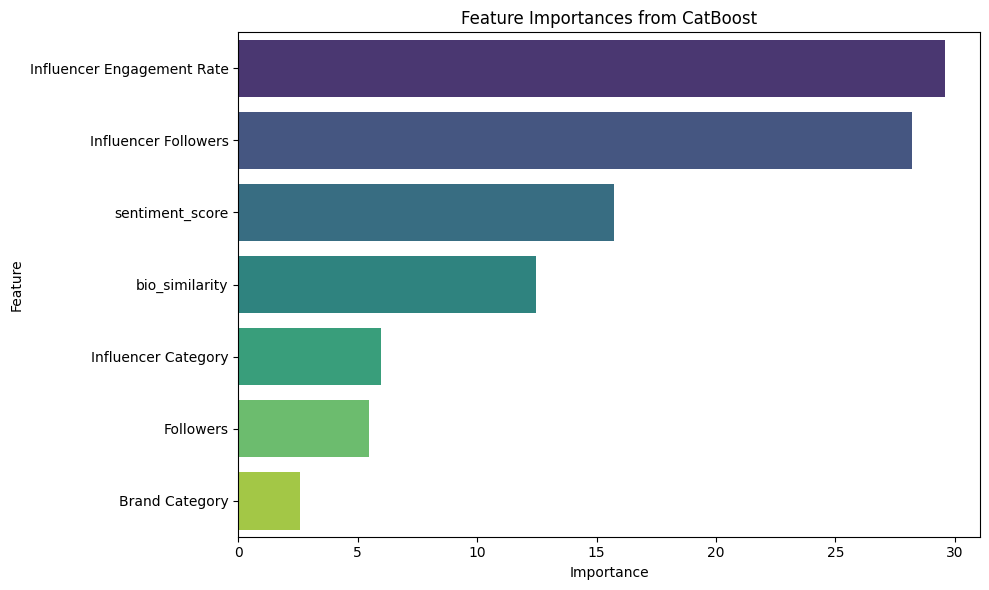

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# === 9. Plot Feature Importances ===
importances = model.get_feature_importance()
feature_names = features

# Create a DataFrame for easier plotting
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
plt.title('Feature Importances from CatBoost')
plt.tight_layout()
plt.show()


In [30]:
influencers_df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,User,Influencer Name,Influencer Category,Followers,Average Likes,Average Comments,Engagement Rate,Bio,sentiment_score
0,silviatodoloquemellama,• Silvia Pérez •,Creators & Celebrities,22899.0,2194.941176,62.705882,10.132988,Fashion | Lifestyle | Romeo's mom,0.0000
1,peppermintandgrapefruit,➕ Jodi ➕ Empowered Mom ➕,Publishers,1880.0,NaN,NaN,NaN,Essential Oils ➕ Boy Mama ➕ dōTERRA 💎 ➕Let’s C...,0.0000
2,rachelclindsay,rachelclindsay,NaN,1259.0,748.909091,38.000000,65.520976,Majority of pics are of my dog! ...,0.9978
3,jaquelinesantosblog,CABELO - CACHOS - TRANSIÇÃO,Creators & Celebrities,72501.0,8036.333333,112.833333,11.395705,"🔝 VEJA OS STORIES🔝 📸 FOTÓGRAFA, DIGITAL INFLUE...",0.0000
4,skincarebysean,Sean 🙋🏽‍♂️,NaN,1896.0,NaN,NaN,NaN,"📍Auckland, New Zealand 📓Honest reviews / Routi...",0.0000
...,...,...,...,...,...,...,...,...,...
38100,visabrina,Sabrina,Home Services,5861.0,NaN,NaN,NaN,Girl mom / Dog mom 👧🏻🐶 📍YVR 🇨🇦 Our colourful ...,0.0000
38101,m.sik,문군(MOONGOON),NaN,21915.0,4433.381443,50.927835,20.694671,🍀 콧노래를 사서 집으로 가자 ⭐️ 네이버 #뷰스타 TOP10 #문군 💄 #패션 #...,0.0000
38102,isabella_garofanelli,Isabella Garofanelli,Creators & Celebrities,134586.0,1914.227273,62.500000,1.515185,✈︎ Licensed #LuxuryTravelAdvisor ⚡︎ @luxurywor...,0.9996
38103,explorewithcassie,ExploreWithCassie,Publishers,11066.0,640.700000,32.400000,6.375384,A #lifestyle and #travel #blog finding the #un...,0.0000


In [31]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer

influencers_df['Bio'] = influencers_df['Bio'].fillna("")
model = SentenceTransformer('all-MiniLM-L6-v2')

# === 4. Encode influencer bios ===
bios = influencers_df['Bio'].tolist()
influencer_embeddings = model.encode(bios, show_progress_bar=True)

# === 5. Save embeddings ===
np.save('influencer_embeddings.npy', influencer_embeddings)

print(" Influencer embeddings saved to 'influencer_embeddings.npy'")


Batches:   0%|          | 0/1191 [00:00<?, ?it/s]

 Influencer embeddings saved to 'influencer_embeddings.npy'


In [32]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# === 1. Load influencer data and precomputed embeddings ===
influencer_embeddings = np.load('influencer_embeddings.npy')

# === 2. Input new brand data ===
brand_bio = "beauty makeup lipgloss"
brand_category = "beauty"
brand_followers = 5000

# === 3. Load sentence transformer and encode brand bio only ===
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
brand_embedding = sentence_model.encode([brand_bio])[0]

# === 4. Compute cosine similarity with precomputed influencer embeddings ===
similarities = cosine_similarity([brand_embedding], influencer_embeddings).flatten()
influencers_df['bio_similarity'] = similarities

# === 5. Clean influencer DataFrame ===
influencers_df['Influencer Category'] = influencers_df['Influencer Category'].fillna('Unknown').astype(str)
influencers_df['Followers'] = influencers_df['Followers'].fillna(0)
influencers_df['Engagement Rate'] = influencers_df['Engagement Rate'].fillna(0)
influencers_df['sentiment_score'] = influencers_df['sentiment_score'].fillna(0)

# === 6. Build DataFrame for model prediction ===
recommendation_df = pd.DataFrame({
    'Brand Category': [brand_category] * len(influencers_df),
    'Influencer Category': influencers_df['Influencer Category'],
    'Influencer Followers': influencers_df['Followers'],
    'Influencer Engagement Rate': influencers_df['Engagement Rate'],
    'Followers': [brand_followers] * len(influencers_df),
    'bio_similarity': influencers_df['bio_similarity'],
    'sentiment_score': influencers_df['sentiment_score']
})

# === 7. Scale numeric features ===
scaler = StandardScaler()
numeric_features = ['Influencer Followers', 'Influencer Engagement Rate', 'Followers', 'sentiment_score']
recommendation_df[numeric_features] = scaler.fit_transform(recommendation_df[numeric_features])

# === 8. Load trained CatBoost model ===
model = CatBoostClassifier()
model.load_model('catboost_model.cbm')

# === 9. Predict sponsorship probability ===
features = [
    'bio_similarity',
    'Influencer Followers',
    'Influencer Engagement Rate',
    'Followers',
    'Brand Category',
    'Influencer Category',
    'sentiment_score'
]

cat_features = ['Brand Category', 'Influencer Category']

recommendation_df['sponsorship_prob'] = model.predict_proba(recommendation_df[features])[:, 1]
recommendation_df['Influencer Username'] = influencers_df['User']  # Change if column is named differently

# === 10. Show top 5 influencer recommendations ===
top_5 = recommendation_df.sort_values(by='sponsorship_prob', ascending=False).head(5)
print(top_5[['Influencer Username', 'Influencer Followers', 'sponsorship_prob',
             'bio_similarity', 'Influencer Engagement Rate', 'sentiment_score']])


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

      Influencer Username  Influencer Followers  sponsorship_prob  \
27841         elkismakeup             -0.100610          0.997091   
20450          nanjamassy             -0.075818          0.996314   
1976       kaan.eyuepoglu             -0.060453          0.990889   
34766        alpha.makeup             -0.079629          0.990485   
9846         claraalinnea             -0.091120          0.990049   

       bio_similarity  Influencer Engagement Rate  sentiment_score  
27841        0.468410                    0.815732         1.104912  
20450        0.561319                   -0.120141        -0.852046  
1976         0.481605                   -0.159456        -0.852046  
34766        0.484055                   -0.153845        -0.852046  
9846         0.524910                   -0.145332        -0.852046  


In [33]:
recommendation_df.head()

,Brand Category,Influencer Category,Influencer Followers,Influencer Engagement Rate,Followers,bio_similarity,sentiment_score,sponsorship_prob,Influencer Username
0,beauty,Creators & Celebrities,-0.083339,-0.125511,0.0,0.261101,-0.852046,0.107560,silviatodoloquemellama
1,beauty,Publishers,-0.100124,-0.201002,0.0,0.244398,-0.852046,0.066508,peppermintandgrapefruit
2,beauty,Unknown,-0.100620,0.287132,0.0,0.074793,1.219514,0.082080,rachelclindsay
3,beauty,Creators & Celebrities,-0.043729,-0.116103,0.0,0.163705,-0.852046,0.100707,jaquelinesantosblog
4,beauty,Unknown,-0.100111,-0.201002,0.0,0.202199,-0.852046,0.067351,skincarebysean


In [34]:
# Fill missing categorical values
final_df['Brand Category'] = final_df['Brand Category'].fillna('Unknown').astype(str)
final_df['Influencer Category'] = final_df['Influencer Category'].fillna('Unknown').astype(str)
final_df['sponsorship_prob'] = model.predict_proba(final_df[features])[:, 1]
def calculate_mrr(df, brand_col='Brand Name', target_col='sponsorship_final', prob_col='sponsorship_prob'):
    mrr_list = []

    for brand, group in df.groupby(brand_col):
        # Sort influencers for this brand by predicted sponsorship probability
        group_sorted = group.sort_values(by=prob_col, ascending=False).reset_index(drop=True)

        # Find the rank of the first actual sponsored influencer (target == 1)
        for rank, row in group_sorted.iterrows():
            if row[target_col] == 1:
                mrr_list.append(1.0 / (rank + 1))
                break
        else:
            mrr_list.append(0.0)  # No sponsored influencer found

    return sum(mrr_list) / len(mrr_list)
mrr_score = calculate_mrr(final_df)
print("MRR Score:", mrr_score)


MRR Score: 0.5261834308691619


In [35]:
def recall_at_k(group, k):
    top_k = group.sort_values('sponsorship_final', ascending=False).head(k)
    total_relevant = group['sponsorship_final'].sum()
    return top_k['sponsorship_final'].sum() / total_relevant if total_relevant != 0 else np.nan



In [36]:
k = 3
recall_scores = final_df.groupby('Brand Username').apply(lambda x: recall_at_k(x, k))
overall_recall_at_k = recall_scores.mean()
print(f"Overall Recall@{k}: {overall_recall_at_k:.4f}")


Overall Recall@3: 0.8888


/tmp/ipykernel_13/4029725990.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recall_scores = final_df.groupby('Brand Username').apply(lambda x: recall_at_k(x, k))
